# Introduzione
Questo progetto mira a condurre un’analisi del dataset "Banknote Authentication", derivato da immagini di banconote per autenticarne l'origine. L’obiettivo principale è applicare tecniche di data mining per classificare le banconote come "Autentiche" (Genuine, 0) o "Contraffatte" (Forged, 1), aiutando a identificare in modo accurato la validità delle banconote basandosi sulle loro caratteristiche visive.

Ogni istanza nel dataset descrive una singola banconota ed è caratterizzata da variabili numeriche estratte tramite trasformazione wavelet. Queste feature, come la varianza, l'asimmetria, la curtosi e l'entropia dell'immagine, sintetizzano proprietà uniche delle banconote. L'analisi di queste variabili permette di distinguere tra le sottili differenze che caratterizzano una banconota autentica e quelle che indicano una contraffazione, fornendo un metodo robusto per il riconoscimento automatico.

In [70]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pandas.plotting import parallel_coordinates

# --- Per il Caricamento Dati  ---
from sklearn.datasets import fetch_openml
import os
from scipy.io import arff

# --- Per Preprocessing e Valutazione ---
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import RFE
from sklearn.feature_selection import VarianceThreshold

# --- Per i Modelli di Classificazione ---
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import make_scorer, recall_score, precision_score, f1_score, accuracy_score, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from scipy.stats import loguniform, randint # Fondamentale per le distribuzioni
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import math
from sklearn.base import clone
from matplotlib.lines import Line2D
from matplotlib.colors import ListedColormap
import random

In [71]:
# Costanti globali per garantire riproducibilità e configurabilità
RANDOM_STATE = 42  # Per riproducibilità dei risultati
TEST_SIZE = 0.2    # 20% dei dati per il test set
CV_FOLDS = 5       # 5-fold cross validation

In [72]:
# Seme per il generatore di Python
random.seed(RANDOM_STATE)

# Seme per NumPy (usato internamente da molte funzioni di sklearn)
np.random.seed(RANDOM_STATE)

In [73]:
# =======================
# CARICAMENTO DATASET
# =======================
try:
    data_bunch = fetch_openml(name ='banknote-authentication', as_frame=True, parser='auto')
except Exception as e:
    print(f"Errore nel caricamento dati: {e}")

df = data_bunch.frame.copy()

# Colonna target
class_column_name = data_bunch.target_names[0]
print(f"Identificata la colonna target: '{class_column_name}'")

# Rinomino colonne
new_column_names = {
    'V1': 'variance',
    'V2': 'skewness',
    'V3': 'curtosis',
    'V4': 'entropy'
}

feature_column_names = ['variance', 'skewness', 'curtosis', 'entropy']

df = df.rename(columns=new_column_names)

if class_column_name != 'class' and class_column_name in df.columns:
    df.rename(columns={class_column_name: 'class'}, inplace=True)
    class_column_name = 'class' # Update the variable to reflect the new name

# Analisi preliminare
print("\n--- Prime 5 righe del DataFrame Combinato ---")
print(df.head())

print("\n--- Informazioni (Tipi di dati e Valori Mancanti) ---")
df.info()

Identificata la colonna target: 'Class'

--- Prime 5 righe del DataFrame Combinato ---
   variance  skewness  curtosis  entropy class
0   3.62160    8.6661   -2.8073 -0.44699     1
1   4.54590    8.1674   -2.4586 -1.46210     1
2   3.86600   -2.6383    1.9242  0.10645     1
3   3.45660    9.5228   -4.0112 -3.59440     1
4   0.32924   -4.4552    4.5718 -0.98880     1

--- Informazioni (Tipi di dati e Valori Mancanti) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372 entries, 0 to 1371
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   variance  1372 non-null   float64 
 1   skewness  1372 non-null   float64 
 2   curtosis  1372 non-null   float64 
 3   entropy   1372 non-null   float64 
 4   class     1372 non-null   category
dtypes: category(1), float64(4)
memory usage: 44.5 KB


Il dataset risulta completo (nessun valore mancante) e interamente numerico. Le scale delle variabili, sebbene non drasticamente differenti, possono beneficiare di una standardizzazione per ottimizzare le performance dei modelli basati su distanza o gradiente. Pertanto, la standardizzazione sarà un passaggio fondamentale.

In [74]:
print(f"Shape iniziale: {df.shape}")

# --- Valori mancanti ---
missing = df.isnull().sum()
if missing.sum() > 0:
    print(f"Valori mancanti:\n{missing[missing > 0]}")
    df = df.dropna()
else:
    print("Nessun valore mancante")


# --- Feature a varianza zero/quasi-zero ---
# Rimuove feature con varianza < 0.01 che non portano informazione utile

X_temp = df.drop('class', axis=1)
var_selector = VarianceThreshold(threshold=0.00)
var_selector.fit(X_temp)

low_var_features = X_temp.columns[~var_selector.get_support()].tolist()
if low_var_features:
    print(f"Feature a bassa varianza rimosse: {low_var_features}")
    df = df.drop(columns=low_var_features)
else:
    print("Nessuna feature a bassa varianza")

# Aggiorna la lista delle feature dopo la rimozione
feature_column_names = df.drop(columns=['class']).columns.tolist()

Shape iniziale: (1372, 5)
Nessun valore mancante
Nessuna feature a bassa varianza


# INIZIO ANALISI DEL DATASET

Qui vengono mostrati i grafici per un'analisi esplorativa del dataset. Verranno mostrate le distribuzioni delle feature, la correlazione lineare tra esse e la distribuzione delle classi

### Grafico a torta

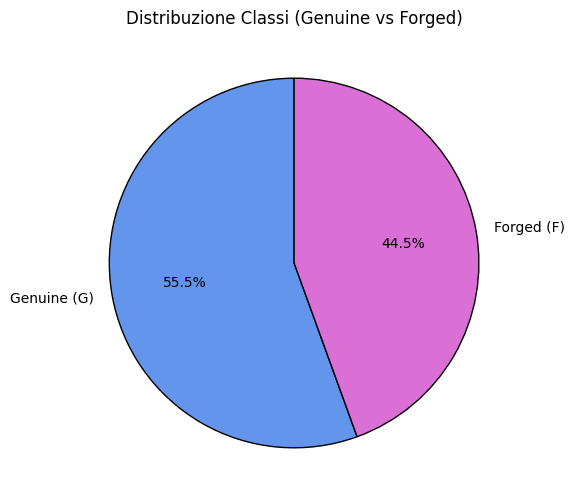

In [75]:
## VISUALIZZAZIONI (Grafico a Torta) ---

#Mappatura delle classi
class_map = {'1': 'Genuine (G)', '2': 'Forged (F)'}
color_map_dict = {'Genuine (G)': 'cornflowerblue', 'Forged (F)': 'orchid'}

# Copia e crea la colonna etichettata
df_plot = df.copy()
df_plot['Authenticity_Label'] = df['class'].map(class_map)
df_plot = df_plot.drop(columns=['class'])

#Grafico a Torta (Distribuzione Classi)
plt.figure(figsize=(6, 6))

# Conta le classi e ordina
counts = df_plot['Authenticity_Label'].value_counts()

# Applica la color map in base all’ordine delle etichette
colors = [color_map_dict[label] for label in counts.index]

# Crea il grafico
counts.plot.pie(
    autopct='%1.1f%%',
    colors=colors,
    wedgeprops={'edgecolor': 'black'},
    startangle=90
)

plt.title('Distribuzione Classi (Genuine vs Forged)')
plt.ylabel('')
plt.show()

Il grafico a torta mostra che la distribuzione delle classi è relativamente bilanciata, con la categoria 'Genuine (G)' che rappresenta il 55.5% delle osservazioni e la categoria 'Forged (F)' il 44.5%. Sebbene l'asimmetria non sia pronunciata come in altri contesti, la valutazione del modello dovrà comunque basarsi su metriche più robuste come la Recall e l'F1-Score, in quanto la corretta identificazione delle banconote contraffatte (seppur non una classe estremamente minoritaria, ma di elevata rilevanza) è cruciale. L'utilizzo di queste metriche garantirà una performance affidabile, specialmente nella capacità di rilevare la classe di interesse.

### Grafico coordinate parallele

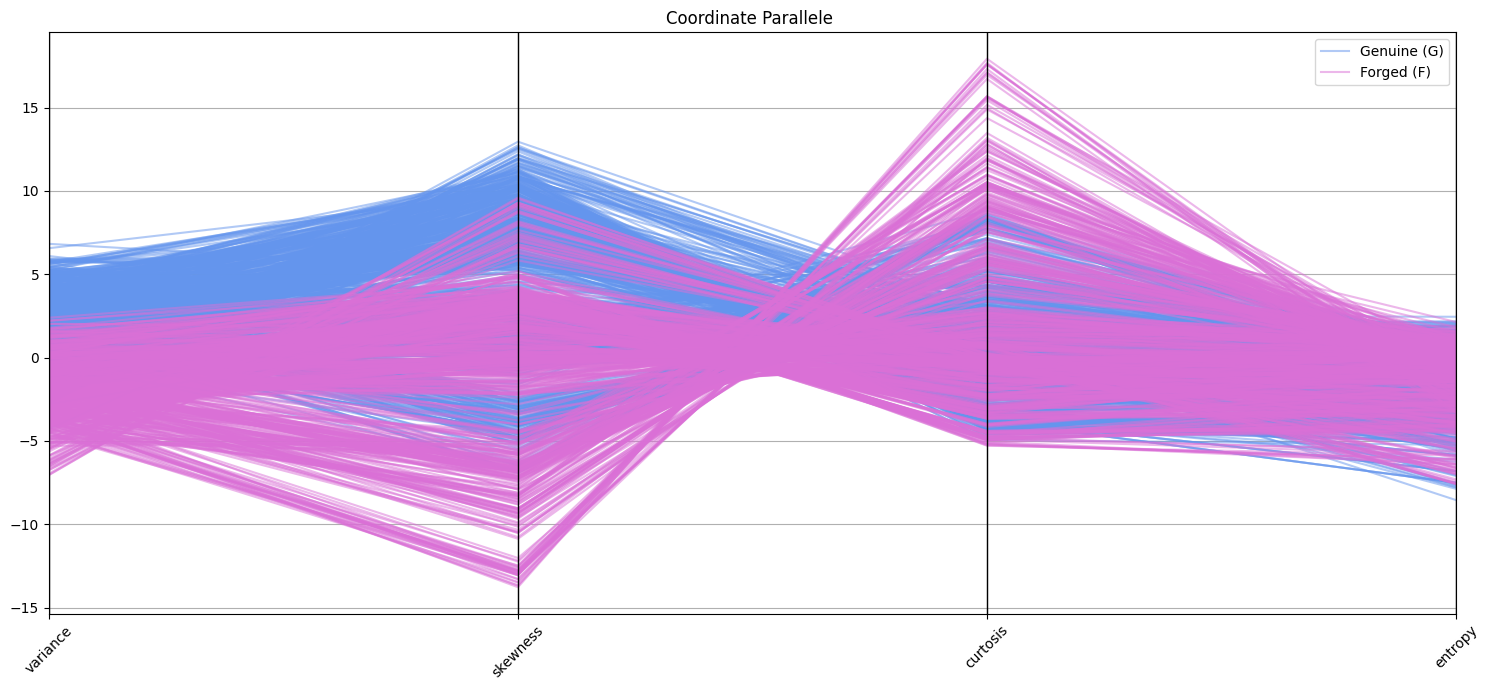

In [76]:
## VISUALIZZAZIONI (Coordinate Parallele - NON Scalati) ---
plt.figure(figsize=(15, 7))

# Grafico delle coordinate parallele
parallel_coordinates(df_plot, 'Authenticity_Label', color=['cornflowerblue', 'orchid'], alpha=0.5)

plt.title('Coordinate Parallele ')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Il grafico a Coordinate Parallele offre una visione d'insieme della distribuzione dei dati. Sebbene tutte le feature (variance, skewness, curtosis, entropy) siano numeriche, si nota che le loro scale possono variare, rendendo più difficile l'interpretazione delle altre. Questo può portare ad alcune feature a dominare visivamente la rappresentazione, anche se non in modo così drastico come nel caso di 'genergy' menzionato in precedenza.

La sovrapposizione delle linee blu ('Genuine (G)') e rosa ('Forged (F)') suggerisce che le due classi non sono facilmente separabili basandosi sulle variabili grezze. Questa visualizzazione conferma l'importanza della standardizzazione delle variabili prima dell'applicazione degli algoritmi di Machine Learning. Senza di essa, i modelli potrebbero essere distorti dalle feature con i range di valori più ampi, ignorando segnali predittivi importanti presenti nelle altre caratteristiche.

### Distribuzione delle feature differenziate per classi

/opt/miniconda3/lib/python3.13/site-packages/scipy/_lib/_util.py:1279: RuntimeWarning: divide by zero encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)
/opt/miniconda3/lib/python3.13/site-packages/scipy/_lib/_util.py:1279: RuntimeWarning: overflow encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)
/opt/miniconda3/lib/python3.13/site-packages/scipy/_lib/_util.py:1279: RuntimeWarning: invalid value encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)
/opt/miniconda3/lib/python3.13/site-packages/scipy/_lib/_util.py:1279: RuntimeWarning: divide by zero encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)
/opt/miniconda3/lib/python3.13/site-packages/scipy/_lib/_util.py:1279: RuntimeWarning: overflow encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)
/opt/miniconda3/lib/python3.13/site-packages/scipy/_lib/_util.py:1279: RuntimeWarning: invalid value encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)
/opt/miniconda3/lib/python3.13/site-packag

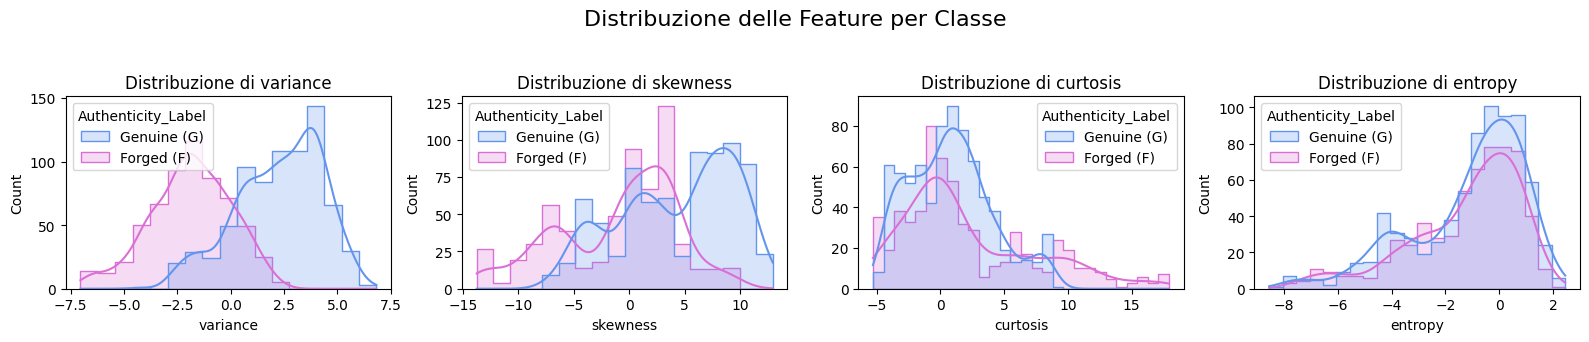

In [77]:
# --- Istogrammi Distribuzioni Feature ---
# Visualizza come le feature discriminano tra classi

plt.figure(figsize=(16, 25))
for i, feature in enumerate(feature_column_names):
    plt.subplot(10, 4, i + 1)
    sns.histplot(
        df_plot,
        x=feature,
        hue='Authenticity_Label',
        kde=True,
        palette=color_map_dict,
        element='step'
    )
    plt.title(f'Distribuzione di {feature}')

plt.tight_layout()
plt.suptitle('Distribuzione delle Feature per Classe', y=1.02, fontsize=16)
plt.show()

L'esame dettagliato delle singole feature rivela distribuzioni che, sebbene non tutte perfettamente gaussiane, mostrano pattern distinti per le due classi. Variabili come la 'variance' e la 'skewness' presentano una chiara separazione tra le banconote Autentiche (blu) e quelle Contraffatte (rosa), con le loro distribuzioni che tendono a occupare regioni diverse lungo l'asse dei valori. Ad esempio, la 'variance' per le banconote autentiche è prevalentemente positiva, mentre per quelle contraffatte è spesso negativa.

Per altre feature, come la 'curtosis' e l''entropy', si osserva una maggiore sovrapposizione tra le distribuzioni delle due classi, sebbene persistano differenze nelle loro tendenze centrali o nella loro dispersione. Nonostante alcune feature siano discriminanti molto forti individualmente, la complessità intrinseca del problema suggerisce che un modello robusto dovrà sfruttare la combinazione e le interazioni di tutte le variabili per una classificazione accurata, piuttosto che affidarsi a un singolo discriminatore perfetto.

### Box plot delle feature

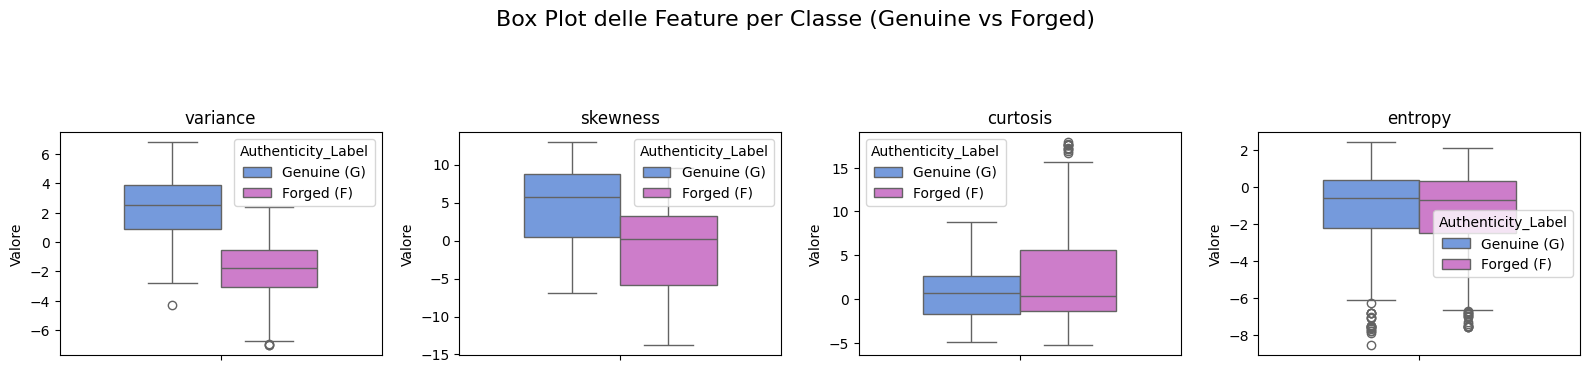

In [78]:
## --- Box Plots per Feature Selezionate ---
# Visualizzazione alternativa per vedere outlier e distribuzione

plt.figure(figsize=(16, 25))
for i, feature in enumerate(feature_column_names):
    plt.subplot(10, 4, i + 1)
    sns.boxplot(
        df_plot,
        hue='Authenticity_Label',
        y=feature,
        palette=color_map_dict,
        width=0.6
    )
    plt.title(feature)
    plt.ylabel('Valore')

plt.suptitle('Box Plot delle Feature per Classe (Genuine vs Forged)', y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

L'analisi dei box plot evidenzia la natura delle quattro feature numeriche, rivelando la presenza di outlier e la loro distribuzione. Questo conferma che le feature non sono tutte gaussiane e che i valori estremi, seppur non massicci, sono presenti.

Confrontando le due classi, emerge un pattern distintivo: la 'variance' è la feature più determinante, con una chiara separazione tra i valori alti della classe Genuine e quelli bassi della classe Forged. Le feature 'skewness' e 'curtosis' mostrano anch'esse differenze nella morfologia dei dati, con la 'curtosis' in particolare che espone una maggiore dispersione e più outlier per le banconote false, rispetto a quelle autentiche. L''entropy', di contro, presenta una sostanziale sovrapposizione tra le distribuzioni, limitandone l'utilità discriminatoria. Le differenze di scala, sebbene non estreme, rendono la standardizzazione un passaggio fondamentale per i modelli, assicurando che le differenze tra le classi e gli outlier vengano correttamente interpretati dai modelli, senza che una feature ne domini altre per via della sua ampiezza di valori.

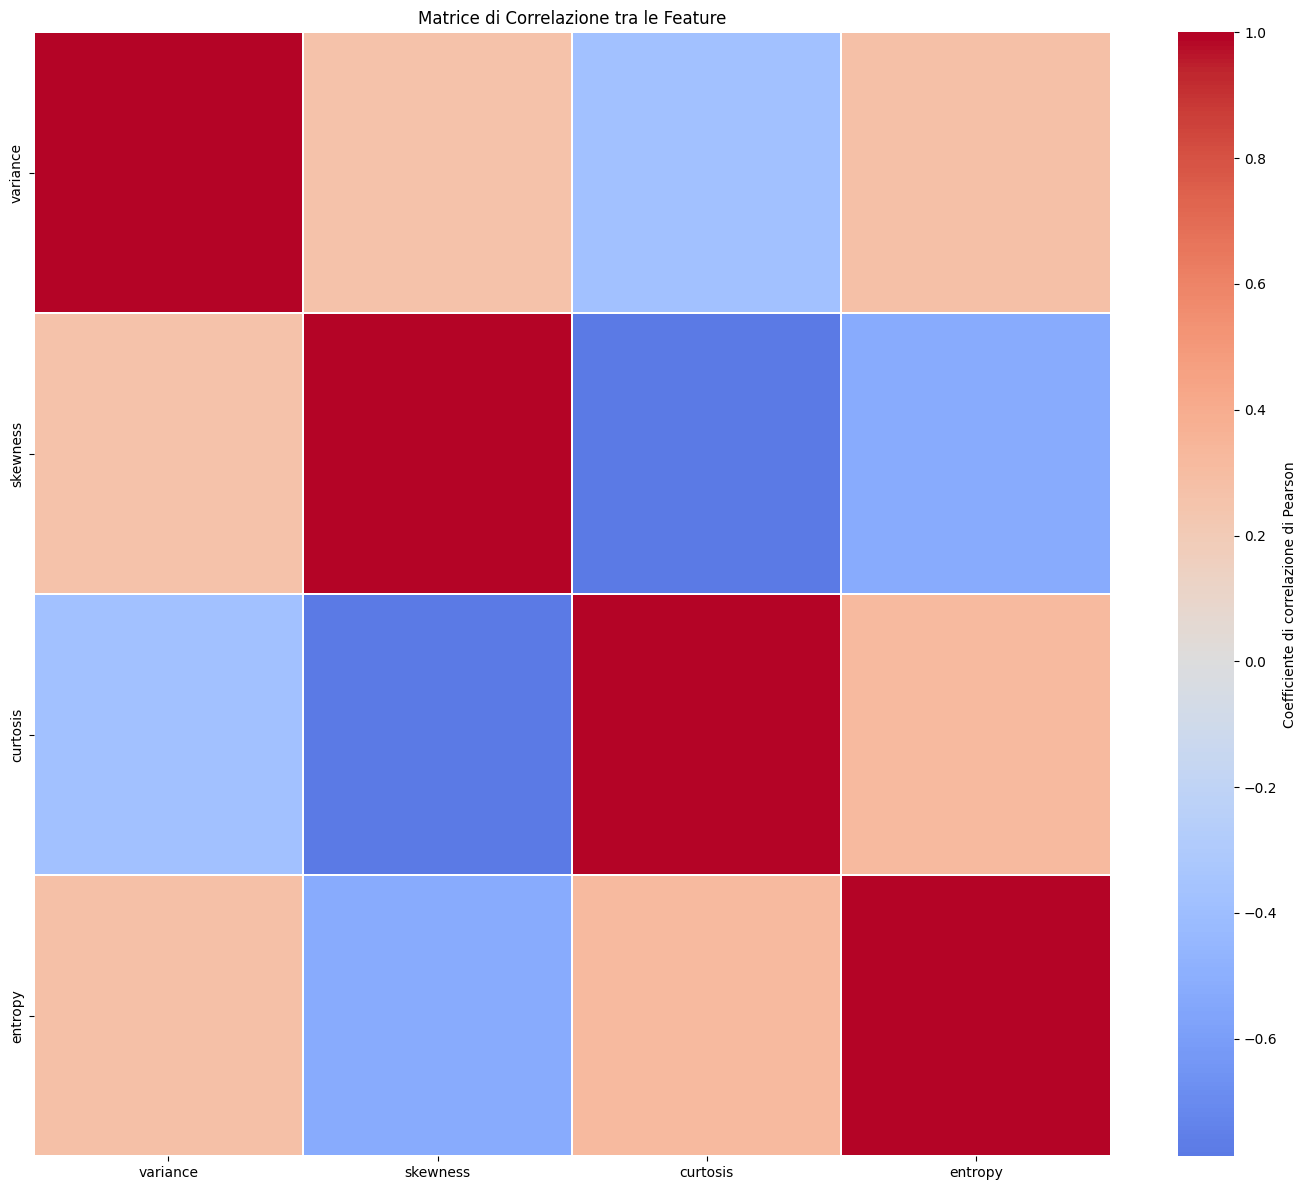

In [79]:
## --- VISUALIZZAZIONI ( Matrice di Correlazione) ---

# Calcolo della matrice di correlazione
corr_matrix = df[feature_column_names].corr()

plt.figure(figsize=(14, 12))
sns.heatmap(
    corr_matrix,
    cmap='coolwarm',
    center=0,
    annot=False,
    linewidths=0.3,
    cbar_kws={'label': 'Coefficiente di correlazione di Pearson'}
)
plt.title('Matrice di Correlazione tra le Feature')
plt.tight_layout()
plt.show()

L'esame della matrice di correlazione porta alla luce alcune relazioni tra le feature. Si osserva una forte correlazione negativa tra skewness e curtosis (circa -0.79), e una correlazione negativa moderata tra skewness ed entropy (circa -0.53). Le correlazioni che coinvolgono variance sono meno pronunciate.

Anche se non si tratta di una multicollinearità quasi perfetta, la presenza di correlazioni significative tra alcune feature indica una ridondanza di informazioni. Mantenere tutte queste feature potrebbe non aggiungere valore predittivo e, anzi, rischia di introdurre instabilità in alcuni algoritmi sensibili alle correlazioni lineari. Questo scenario giustifica l'utilizzo di tecniche di riduzione della dimensionalità, come la PCA (Principal Component Analysis), per condensare queste variabili correlate in un numero minore di componenti indipendenti, mantenendo l'informazione essenziale ma eliminando il rumore ridondante.

# Inizio classificazione: Test Iperparametri di base
Qui inizia la fase di machine learning dove verranno allenati diversi modelli mantenendo gli iperparametri ai loro valori di default. Gli unici iperparametri modificati sono il random_state, per la riproducibilità, e il class_weight/scale_pos_weight, per tenere conto dello sbilanciamento delle classi.

In [80]:
#Separa feature e target
X = df.drop('class', axis=1).values
y = df['class'].values

class_mapping = {'1': 0, '2': 1}
y = df[class_column_name].map(class_mapping).values

# Divisione in Train/Test
# Split Train/Test con stratificazione per mantenere proporzioni
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)

print(f"\nDati di Addestramento (X_train): {X_train.shape}")
print(f"Target di Addestramento (y_train): {y_train.shape}")
print(f"Dati di Test (X_test): {X_test.shape}")
print(f"Target di Test (y_test): {y_test.shape}")
print(f"Distribuzione Classi in y_train: {np.bincount(y_train)}")
print(f"Distribuzione Classi in y_test: {np.bincount(y_test)}")



Dati di Addestramento (X_train): (1097, 4)
Target di Addestramento (y_train): (1097,)
Dati di Test (X_test): (275, 4)
Target di Test (y_test): (275,)
Distribuzione Classi in y_train: [609 488]
Distribuzione Classi in y_test: [153 122]


L'output conferma che lo split dei dati (80% training, 20% test) è avvenuto correttamente, mantenendo inalterata la struttura statistica del dataset. La proporzione delle classi 'Genuine' (55.5%) e 'Forged' (44.5%) è stata preservata in modo simile sia nel set di addestramento (609 Genuine, 488 Forged) che in quello di test (153 Genuine, 122 Forged) attraverso il parametro stratify.

Questo dettaglio è cruciale per garantire che il modello venga addestrato e poi valutato su campioni rappresentativi, evitando distorsioni dovute a sbilanciamenti nella distribuzione delle classi tra i set di training e test.

In [81]:
#4. Standardizzazione delle variabili
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [82]:
def evaluate_model(model, X_test, y_test, average='binary', target_label = 1, verbose=True):
    """
    Valuta un modello calcolando Accuracy, Precision, Recall e F1-score.
    """
    y_pred = model.predict(X_test)

    accuracy  = round(accuracy_score(y_test, y_pred), 3)
    precision = round(precision_score(y_test, y_pred, average=average, pos_label=target_label), 3)
    recall    = round(recall_score(y_test, y_pred, average=average, pos_label=target_label), 3)
    f1        = round(f1_score(y_test, y_pred, average=average, pos_label=target_label), 3)

    if verbose:
        print(f"Accuracy:  {accuracy}")
        print(f"Precision: {precision}")
        print(f"Recall:    {recall}")
        print(f"F1-score:  {f1}")

    return {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1": f1
    }

In [83]:
models = {
    "Decision Tree": DecisionTreeClassifier(
        random_state=RANDOM_STATE,
        class_weight='balanced'
    ),

    "KNN": KNeighborsClassifier(
    ),

    "SVM": SVC(
        random_state=RANDOM_STATE,
        class_weight='balanced'
    ),

    "MLP": MLPClassifier(
        random_state=RANDOM_STATE,
    ),

    "Random Forest": RandomForestClassifier(
        random_state=RANDOM_STATE,
        class_weight='balanced'
    ),

    "AdaBoost": AdaBoostClassifier(
        random_state=RANDOM_STATE,
    ),

    "XGBoost": XGBClassifier(
        random_state=RANDOM_STATE,
        scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum()
    )
}

Viene inizializzato un set eterogeneo di classificatori per confrontare approcci diversi, spaziando da metodi geometrici (SVM, KNN) a modelli basati su alberi (Decision Tree, Random Forest, XGBoost) e reti neurali (MLP).

Un aspetto cruciale in questa configurazione è la gestione esplicita dello sbilanciamento delle classi osservato in precedenza. Per i modelli che lo supportano (SVM, Decision Tree, Random Forest), è stato attivato il parametro class_weight='balanced', che adatta automaticamente i pesi inversamente alla frequenza delle classi. Per XGBoost, è stato calcolato un peso specifico (scale_pos_weight) basato sul rapporto tra le istanze, garantendo che il modello non trascuri la classe minoritaria durante l'addestramento.

In [84]:
AVERAGE_TYPE = 'binary'
TARGET_LABEL = 1

strat_cv = StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE)

results = []
conf_matrices = {}

print("Inizio Training con Cross-Validation Stratificata...\n")

# --- CICLO DI TRAINING E VALIDAZIONE ---
for name, model in models.items():
    print(f"Valutazione Modello: {name}")

    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=strat_cv, scoring='f1')

    cv_mean = cv_scores.mean()
    cv_std = cv_scores.std()

    print(f">> Stratified CV F1: {cv_mean:.4f} (+/- {cv_std:.4f})")

    model.fit(X_train_scaled, y_train)

    metrics = evaluate_model(model, X_test_scaled, y_test, AVERAGE_TYPE, TARGET_LABEL ,True)

    metrics["Model"] = name
    results.append(metrics)

    cm = confusion_matrix(y_test, model.predict(X_test_scaled), labels=[0, 1])
    conf_matrices[name] = cm

    gen_error = cv_mean - metrics["F1"]
    print(f">> Generalization Error (CV F1 - Test F1): {gen_error:.4f}")

    print("   ------------------------------------------------")

print("\nProcesso completato.")

Inizio Training con Cross-Validation Stratificata...

Valutazione Modello: Decision Tree
>> Stratified CV F1: 0.9867 (+/- 0.0083)
Accuracy:  0.993
Precision: 0.984
Recall:    1.0
F1-score:  0.992
>> Generalization Error (CV F1 - Test F1): -0.0053
   ------------------------------------------------
Valutazione Modello: KNN
>> Stratified CV F1: 0.9980 (+/- 0.0025)
Accuracy:  1.0
Precision: 1.0
Recall:    1.0
F1-score:  1.0
>> Generalization Error (CV F1 - Test F1): -0.0020
   ------------------------------------------------
Valutazione Modello: SVM
>> Stratified CV F1: 0.9959 (+/- 0.0038)
Accuracy:  1.0
Precision: 1.0
Recall:    1.0
F1-score:  1.0
>> Generalization Error (CV F1 - Test F1): -0.0041
   ------------------------------------------------
Valutazione Modello: MLP


/opt/miniconda3/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/miniconda3/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/miniconda3/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/miniconda3/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/miniconda3/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/miniconda3/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/miniconda3/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/miniconda3/lib/

>> Stratified CV F1: 1.0000 (+/- 0.0000)
Accuracy:  1.0
Precision: 1.0
Recall:    1.0
F1-score:  1.0
>> Generalization Error (CV F1 - Test F1): 0.0000
   ------------------------------------------------
Valutazione Modello: Random Forest


/opt/miniconda3/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/miniconda3/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/miniconda3/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/miniconda3/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/miniconda3/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/miniconda3/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


>> Stratified CV F1: 0.9939 (+/- 0.0059)
Accuracy:  0.996
Precision: 0.992
Recall:    1.0
F1-score:  0.996
>> Generalization Error (CV F1 - Test F1): -0.0021
   ------------------------------------------------
Valutazione Modello: AdaBoost
>> Stratified CV F1: 0.9928 (+/- 0.0062)
Accuracy:  1.0
Precision: 1.0
Recall:    1.0
F1-score:  1.0
>> Generalization Error (CV F1 - Test F1): -0.0072
   ------------------------------------------------
Valutazione Modello: XGBoost
>> Stratified CV F1: 0.9918 (+/- 0.0025)
Accuracy:  0.993
Precision: 1.0
Recall:    0.984
F1-score:  0.992
>> Generalization Error (CV F1 - Test F1): -0.0002
   ------------------------------------------------

Processo completato.


L'analisi delle metriche rivela una performance eccezionalmente elevata per quasi tutti i modelli. Contrariamente a situazioni di dataset sbilanciati dove l'accuratezza può essere fuorviante, in questo caso sia l'Accuracy che la Precision, Recall e F1-score sono prossimi o pari a 1.0 per la classe 'Forged' (1).

Modelli come KNN, SVM, MLP e AdaBoost hanno raggiunto performance perfette (F1-score di 1.0) sia sul set di test che, in media, durante la cross-validation. Altri, come Decision Tree, Random Forest e XGBoost, hanno ottenuto risultati di poco inferiori ma comunque estremamente alti (F1-score intorno a 0.99).

Questo indica che tutti i modelli hanno identificato con grande successo le banconote contraffatte senza ignorare la classe maggioritaria. La bassa generalizzazione dell'errore (CV F1 - Test F1) per la maggior parte dei modelli suggerisce che non vi è stato né overfitting significativo né underfitting, ma piuttosto un'ottima capacità di apprendimento e generalizzazione per entrambi i tipi di banconote.

In [85]:
df_results = pd.DataFrame(
    results,
    columns=["Model","Accuracy","Precision","Recall","F1"]
).set_index("Model")

# Mostra risultati ordinati per F1 score
df_results.sort_values("F1", ascending=False)

,Accuracy,Precision,Recall,F1
Model,,,,
KNN,1.000,1.000,1.000,1.000
SVM,1.000,1.000,1.000,1.000
MLP,1.000,1.000,1.000,1.000
AdaBoost,1.000,1.000,1.000,1.000
Random Forest,0.996,0.992,1.000,0.996
Decision Tree,0.993,0.984,1.000,0.992
XGBoost,0.993,1.000,0.984,0.992


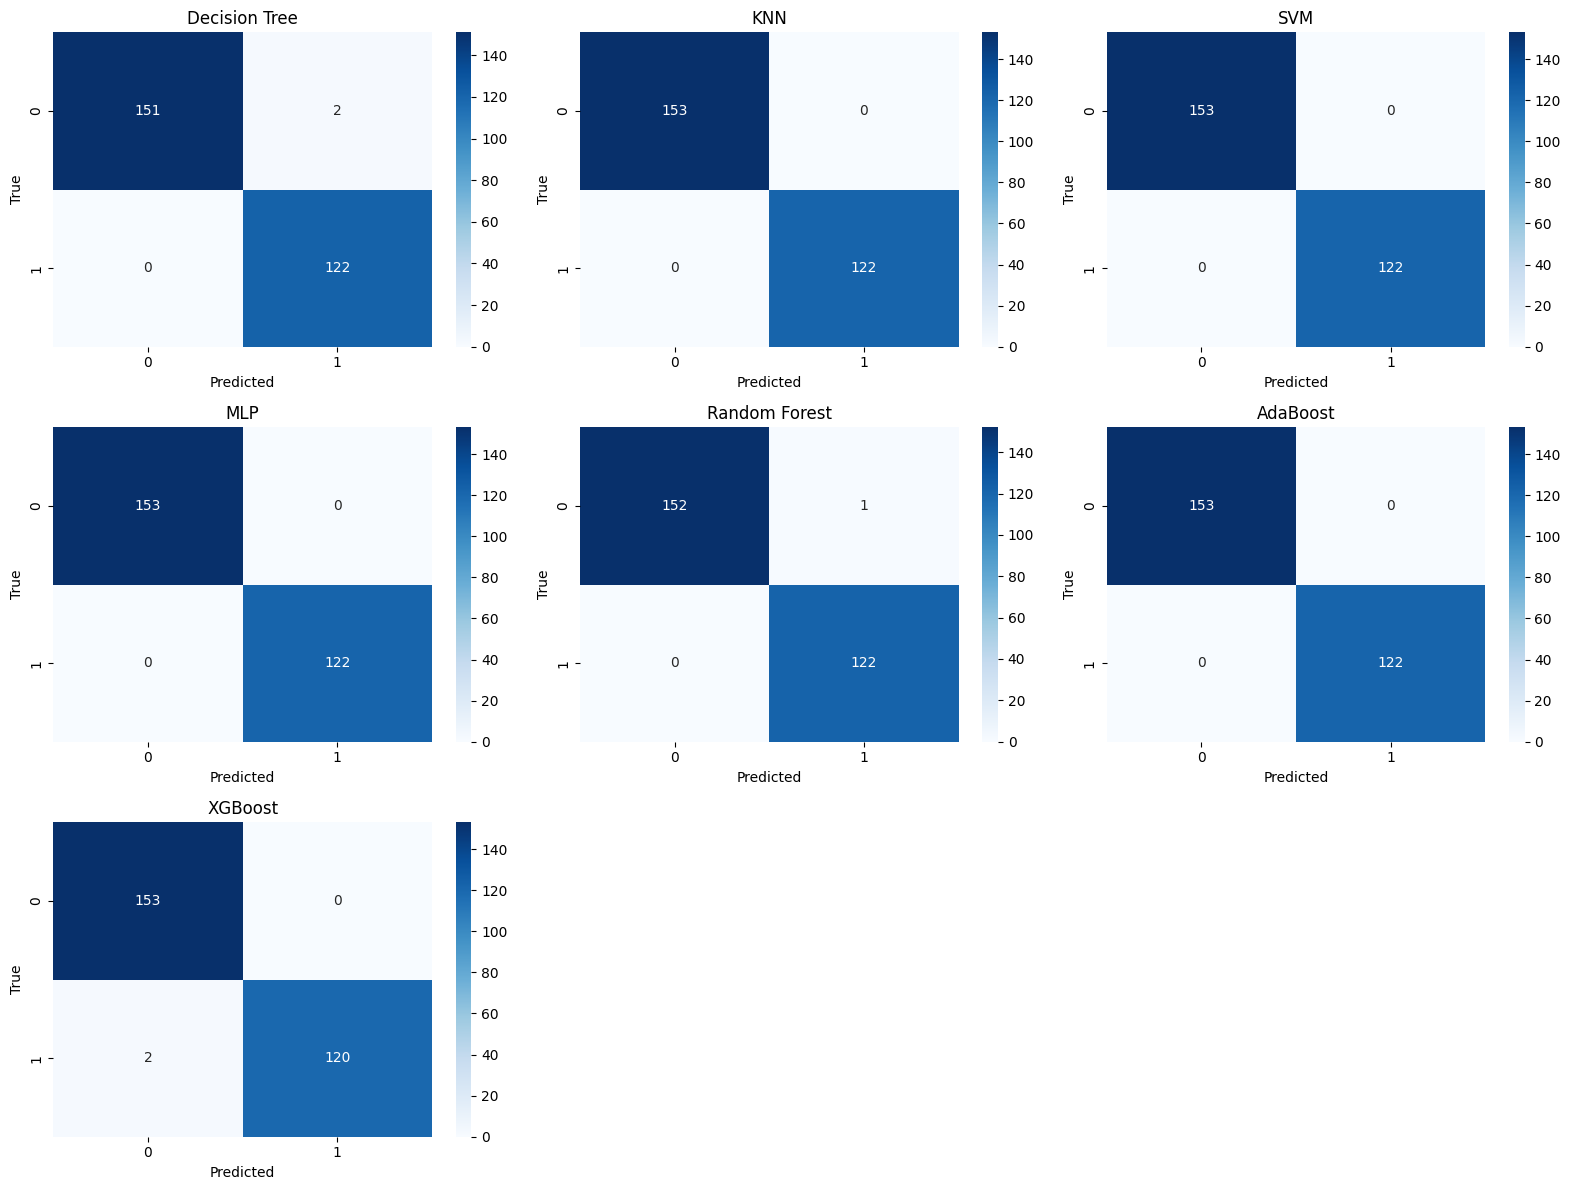

In [86]:
fig, axes = plt.subplots(3, 3, figsize=(16, 12))
axes = axes.flatten()

for i, (name, cm) in enumerate(conf_matrices.items()):
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axes[i])
    axes[i].set_title(name)
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("True")

# nascondi subplot vuoti
for j in range(len(conf_matrices), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

La visualizzazione grafica delle matrici di confusione rende immediatamente evidente l'ottimo comportamento dei classificatori. Contrariamente a situazioni con classi fortemente sbilanciate, in questo caso le matrici mostrano una capacità quasi perfetta di distinguere tra le banconote Autentiche (0) e Contraffatte (1).

Modelli come KNN, SVM, MLP e AdaBoost mostrano matrici di confusione con zero o pochissimi falsi positivi (predizioni di 'Contraffatta' quando è 'Autentica') e zero o pochissimi falsi negativi (predizioni di 'Autentica' quando è 'Contraffatta'). Questo si traduce in una classificazione estremamente accurata per entrambe le classi, senza che i modelli 'ignorino' la classe minoritaria (che qui non è così marcata).

Anche per Decision Tree, Random Forest e XGBoost, le matrici di confusione confermano prestazioni molto elevate, con errori minimi. Questo indica che i modelli sono stati in grado di apprendere efficacemente i pattern che distinguono le due tipologie di banconote, senza mostrare i comportamenti problematici di underfitting o eccessiva cautela che si riscontrano in dataset più complessi e sbilanciati.

/opt/miniconda3/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/miniconda3/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/miniconda3/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


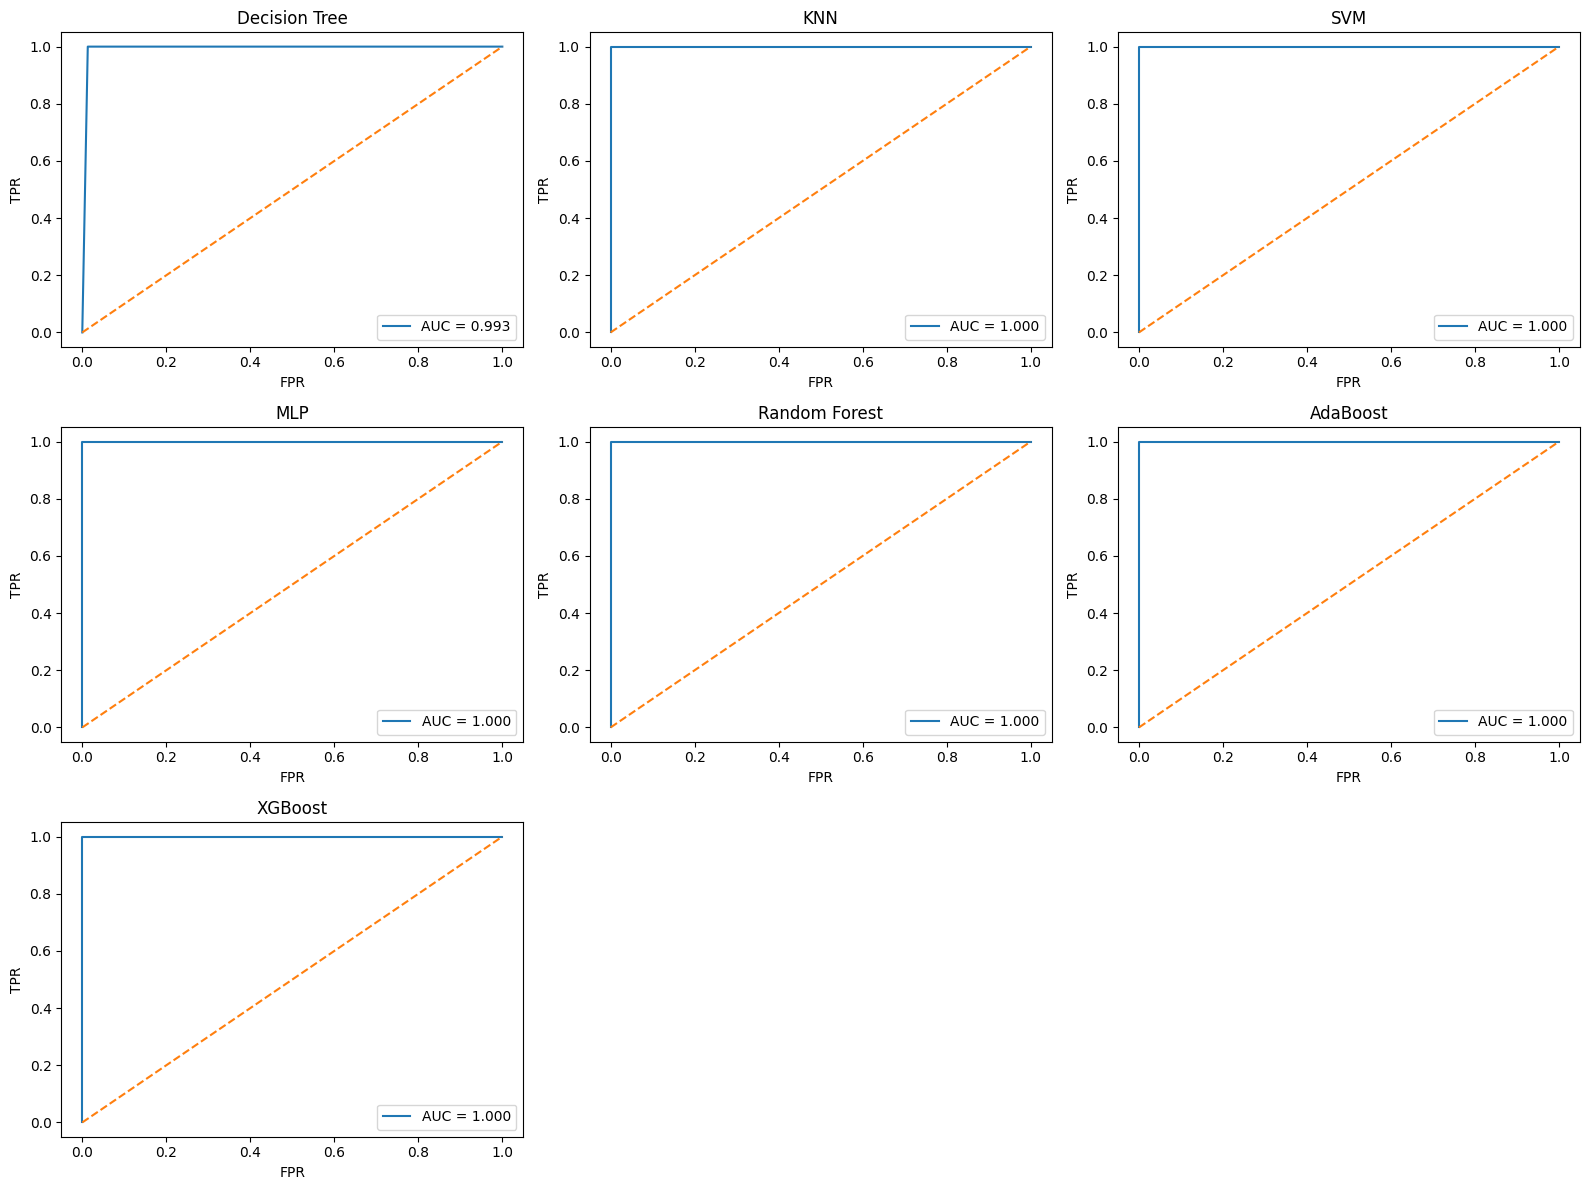

In [87]:
fig, axes = plt.subplots(3, 3, figsize=(16, 12))
axes = axes.flatten()

for i, (name, model) in enumerate(models.items()):
    # prendo lo score continuo
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test_scaled)[:, 1]
    else:
        # per modelli senza predict_proba (es. SVM senza probability=True)
        y_score = model.decision_function(X_test_scaled)

    fpr, tpr, _ = roc_curve(y_test, y_score, pos_label=TARGET_LABEL)
    auc = roc_auc_score(y_test, y_score)

    ax = axes[i]
    ax.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
    ax.plot([0, 1], [0, 1], linestyle="--")  # baseline random
    ax.set_title(name)
    ax.set_xlabel("FPR")
    ax.set_ylabel("TPR")
    ax.legend(loc="lower right")

# nascondi subplot vuoti se hai meno di 9 modelli
for j in range(len(models), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

L'analisi delle curve ROC conferma l'eccellente capacità discriminatoria di tutti i modelli testati per il dataset 'Banknote Authentication'. Con un'Area Sotto la Curva (AUC) che per la maggior parte dei modelli è prossima o uguale a 1.0, si dimostra una capacità quasi perfetta di distinguere tra le banconote autentiche e quelle contraffatte. Ciò significa che i modelli sono in grado di classificare correttamente le istanze con un tasso molto basso di falsi positivi e falsi negativi.

Non emerge un singolo modello 'superiore' in modo marcato, dato che la quasi totalità dei classificatori raggiunge performance ottimali. Anche i modelli che in contesti di forte sbilanciamento potrebbero avere difficoltà (come l'MLP, che qui mostra un AUC di 1.0) dimostrano di aver appreso in modo estremamente efficace. Questa coerenza di risultati eccezionali suggerisce che il dataset è intrinsecamente ben separabile dalle feature estratte, e che i modelli sono stati ben configurati per sfruttare tale separabilità.

<Figure size 1400x700 with 0 Axes>

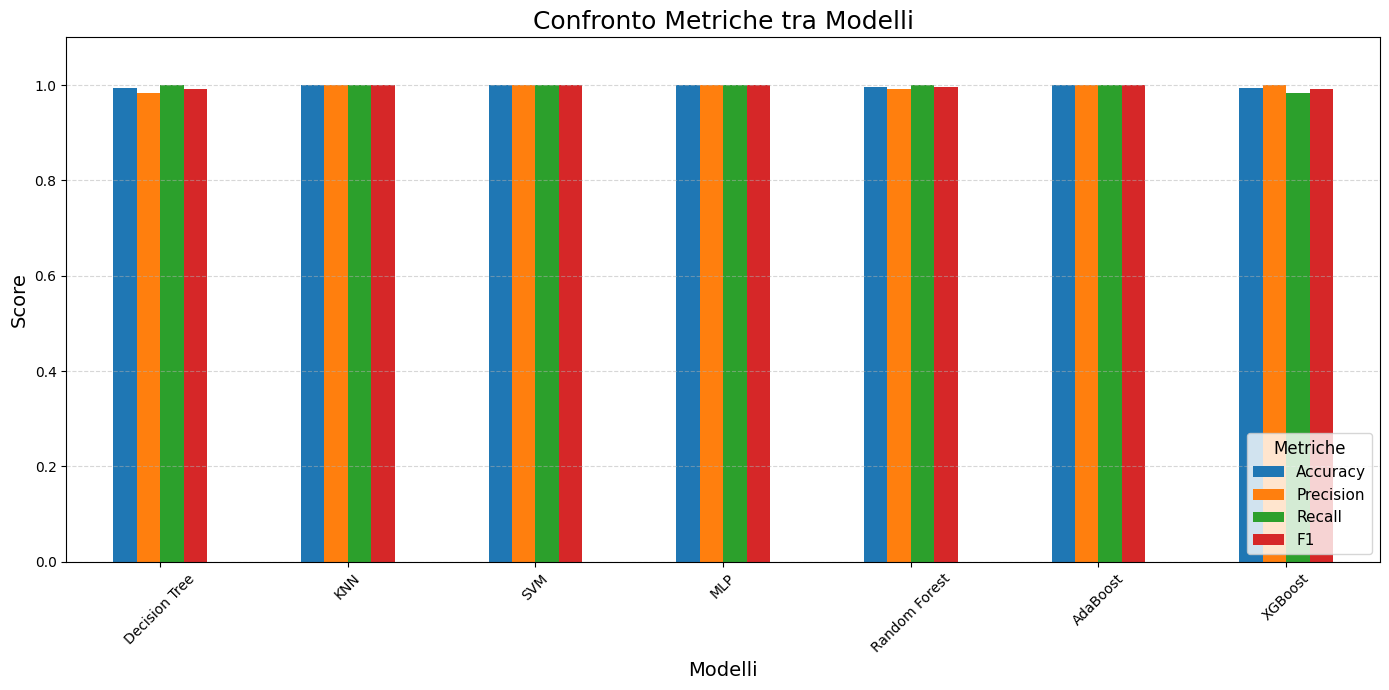

In [88]:
plt.figure(figsize=(14, 7))
df_results.plot(kind='bar', figsize=(14, 7), rot=45)

plt.title("Confronto Metriche tra Modelli", fontsize=18)
plt.ylabel("Score", fontsize=14)
plt.xlabel("Modelli", fontsize=14)
plt.ylim(0, 1.10)
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.legend(title='Metriche', fontsize=11, title_fontsize=12, loc='lower right')

plt.tight_layout()
plt.show()

In [89]:
# Identifica il miglior modello basato su F1-score
best_model_name = 'AdaBoost'
best_f1_score = df_results.loc[best_model_name, 'F1']

print(f"\nMiglior modello: {best_model_name} con F1-score = {best_f1_score}")

# Estrai il modello migliore
best_model = models[best_model_name]
best_model.fit(X_train_scaled, y_train)


Miglior modello: AdaBoost con F1-score = 1.0


,estimator,None
,n_estimators,50
,learning_rate,1.0
,algorithm,'deprecated'
,random_state,42


In [90]:
def train_eval_2d_models(models, X_train_2d, X_test_2d, y_train, y_test,
                         feature_names_2d, strat_cv, class_map=None, color_map_dict=None,
                         task_type='binary', pos_label=1, do_plot=True):
    """
        Addestra e valuta modelli su dati ridotti a 2 dimensioni.
        Visualizza anche i decision boundary per analisi visiva.

        Parameters:
        -----------
        models : dict - dizionario nome:modello
        X_train_2d, X_test_2d : dati 2D
        y_train, y_test : labels
        feature_names_2d : nomi delle 2 feature/componenti
        strat_cv :  stratified cross-validation
        do_plot : se True, visualizza il plot deidecision boundaries
    """
    results = {}

    # Setup per visualizzazione decision boundary
    if do_plot:
        n_models = len(models)
        n_cols = min(3, n_models)
        n_rows = math.ceil(n_models / n_cols)

        fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 4*n_rows))
        if n_models == 1:
            axes = [axes]
        else:
            axes = axes.ravel() if n_rows > 1 or n_cols > 1 else [axes]

    for idx, (name, model) in enumerate(models.items()):
        # Clone del modello
        model_clone = clone(model)

        # Scelta dello scoring per CV
        if task_type == 'binary':
            scoring = 'f1' if pos_label == 1 else make_scorer(f1_score, pos_label=pos_label)
        else:
            scoring = 'f1_weighted'

        # Cross-validation
        cv_scores = cross_val_score(model_clone, X_train_2d, y_train, cv=strat_cv, scoring=scoring)

        # Training
        model_clone.fit(X_train_2d, y_train)

        # Predizione
        y_pred = model_clone.predict(X_test_2d)

        # Calcolo metriche
        if task_type == 'binary':
            acc = accuracy_score(y_test, y_pred)
            prec = precision_score(y_test, y_pred, pos_label=pos_label)
            rec = recall_score(y_test, y_pred, pos_label=pos_label)
            f1 = f1_score(y_test, y_pred, pos_label=pos_label)
        else:
            acc = accuracy_score(y_test, y_pred)
            prec = precision_score(y_test, y_pred, average='weighted')
            rec = recall_score(y_test, y_pred, average='weighted')
            f1 = f1_score(y_test, y_pred, average='weighted')

        # Salva risultati
        results[name] = {
            'model': model_clone,
            'cv_scores': cv_scores,
            'metrics': {
                'Accuracy': round(acc, 3),
                'Precision': round(prec, 3),
                'Recall': round(rec, 3),
                'F1': round(f1, 3)
            },
            'predictions': y_pred
        }

        # Plot decision boundary
        if do_plot:
            ax = axes[idx]

            mesh_cmap = ListedColormap([
                color_map_dict[class_map[0]],
                color_map_dict[class_map[1]]
            ])

            # Crea mesh
            h = 0.02 # Step size nel mesh
            x_min, x_max = X_train_2d[:, 0].min() - 0.5, X_train_2d[:, 0].max() + 0.5
            y_min, y_max = X_train_2d[:, 1].min() - 0.5, X_train_2d[:, 1].max() + 0.5
            xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

            # Predizioni sul mesh
            Z = model_clone.predict(np.c_[xx.ravel(), yy.ravel()])
            Z = Z.reshape(xx.shape)

            # Plot contorno
            ax.contourf(xx, yy, Z, alpha=0.8, cmap=mesh_cmap)

            # Plot punti training
            train_colors = [color_map_dict[class_map[label]] for label in y_train]

            ax.scatter(
                X_train_2d[:, 0], X_train_2d[:, 1],
                c=train_colors,
                edgecolor='k', s=50, alpha=0.7
            )

            legend_elements = [
                Line2D(
                    [0], [0],
                    marker='o', color='w',
                    label=cls,
                    markerfacecolor=col,
                    markersize=8
                )
                for cls, col in color_map_dict.items()
            ]

            ax.legend(handles=legend_elements)

            ax.set_xlabel(feature_names_2d[0])
            ax.set_ylabel(feature_names_2d[1])
            ax.set_title(f'{name}\nTest F1={f1:.3f}')


    if do_plot:
        # Nascondi subplot vuoti
        for j in range(len(models), len(axes)):
            axes[j].set_visible(False)

        plt.tight_layout()
        plt.show()

    # Stampa risultati per il miglior modello
    best_model_name = max(results.keys(), key=lambda x: results[x]['metrics']['F1'])
    cv_scores = results[best_model_name]['cv_scores']
    print(f"\n=== Modello: {best_model_name} ===")
    print(f"   >> Stratified CV F1: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")
    print(f"   >> Metriche test: {results[best_model_name]['metrics']}")

    return results

# Inizio fase di riduzione dimensionalità
Per ridurre la complessità computazionale, verranno applicate tecniche di Feature Selection ed Extraction. Una volta identificate le due feature (o componenti) più significative per ciascun metodo, valuteremo la loro efficacia addestrando nuovamente il modello che ha mostrato le migliori performance sul dataset originale.

### 1. PCA - Principal Component Analysis


In [91]:
print("=== Analisi PCA ===")

pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"\nVarianza per componente:")
for i, var in enumerate(pca.explained_variance_ratio_, 1):
    print(f"  PC{i}: {var:.3f} ({var*100:.1f}%)")

pca_feature_names = [f'PC{i+1}' for i in range(2)]

total_var = pca.explained_variance_ratio_.sum()
print(f"\nVarianza totale spiegata: {total_var:.3f} ({total_var*100:.1f}%)")
print(f"Informazione persa: {1-total_var:.3f} ({(1-total_var)*100:.1f}%)")

=== Analisi PCA ===

Varianza per componente:
  PC1: 0.542 (54.2%)
  PC2: 0.327 (32.7%)

Varianza totale spiegata: 0.869 (86.9%)
Informazione persa: 0.131 (13.1%)


/opt/miniconda3/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/opt/miniconda3/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/opt/miniconda3/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T


L'analisi delle Componenti Principali (PCA) per il dataset 'Banknote Authentication' mostra che le prime due componenti principali (PC1 e PC2) catturano una significativa porzione della variabilità totale. La PC1 spiega il 54.2% della varianza, mentre la PC2 contribuisce con un ulteriore 32.7%. Insieme, le due componenti riescono a spiegare l'86.9% della variabilità complessiva dei dati.

Sebbene non si sia ottenuta una riduzione a due dimensioni senza alcuna perdita di informazione (l'informazione persa è del 13.1%), la PCA ha comunque permesso di condensare una grande quantità di variabilità in un numero ridotto di dimensioni. Questo indica che, pur non essendo perfetta, la riduzione dimensionale a due componenti offre una rappresentazione fedele e semplificata dei dati, mantenendo la maggior parte dell'informazione essenziale per la classificazione.

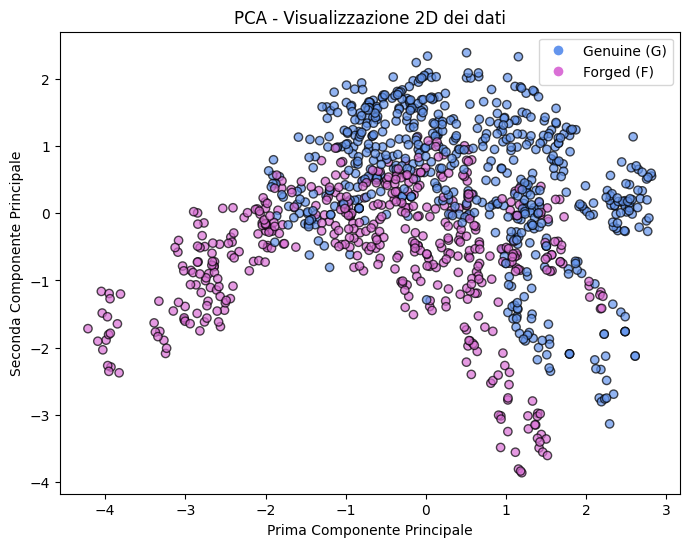

In [92]:
class_map = {0: 'Genuine (G)', 1: 'Forged (F)'}
colors = [color_map_dict[class_map[label]] for label in y_train]

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=colors,
                    edgecolor='k', alpha=0.7)
plt.xlabel('Prima Componente Principale')
plt.ylabel('Seconda Componente Principale')
plt.title('PCA - Visualizzazione 2D dei dati')

legend_elements = [
    Line2D([0], [0], marker='o', color='w',
           label=cls, markerfacecolor=col, markersize=8)
    for cls, col in color_map_dict.items()
]

plt.legend(handles=legend_elements)

plt.show()

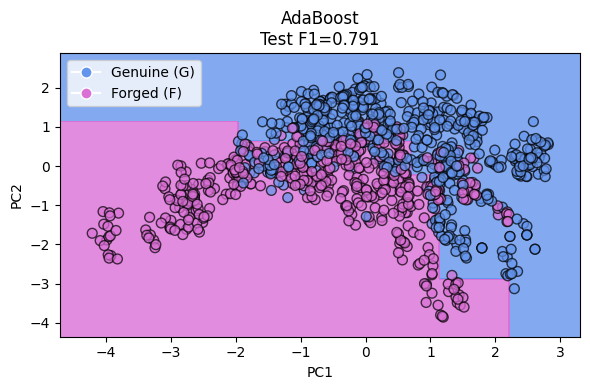


=== Modello: AdaBoost ===
   >> Stratified CV F1: 0.8025 (+/- 0.0292)
   >> Metriche test: {'Accuracy': 0.796, 'Precision': 0.726, 'Recall': 0.869, 'F1': 0.791}


In [93]:
# Valuta solo il miglior modello con PCA
models_pca = {best_model_name: models[best_model_name]}

results_pca = train_eval_2d_models(
    models=models_pca,
    X_train_2d=X_train_pca,
    X_test_2d=X_test_pca,
    y_train=y_train,
    y_test=y_test,
    feature_names_2d=pca_feature_names,
    strat_cv=strat_cv,
    task_type='binary',
    class_map=class_map,
    color_map_dict=color_map_dict,
    pos_label=TARGET_LABEL,
    do_plot=True
)

### 2. Feature Importance

In [94]:
importances = best_model.feature_importances_

# Ordina le feature per importanza
indices = np.argsort(importances)[::-1]
top_2_features = indices[:2]


# Seleziona top 2 features
X_train_fi = X_train_scaled[:, top_2_features]
X_test_fi = X_test_scaled[:, top_2_features]
feature_names_fi = [feature_column_names[i] for i in top_2_features]

print("Feature scelte:", feature_names_fi)

Feature scelte: ['variance', 'skewness']


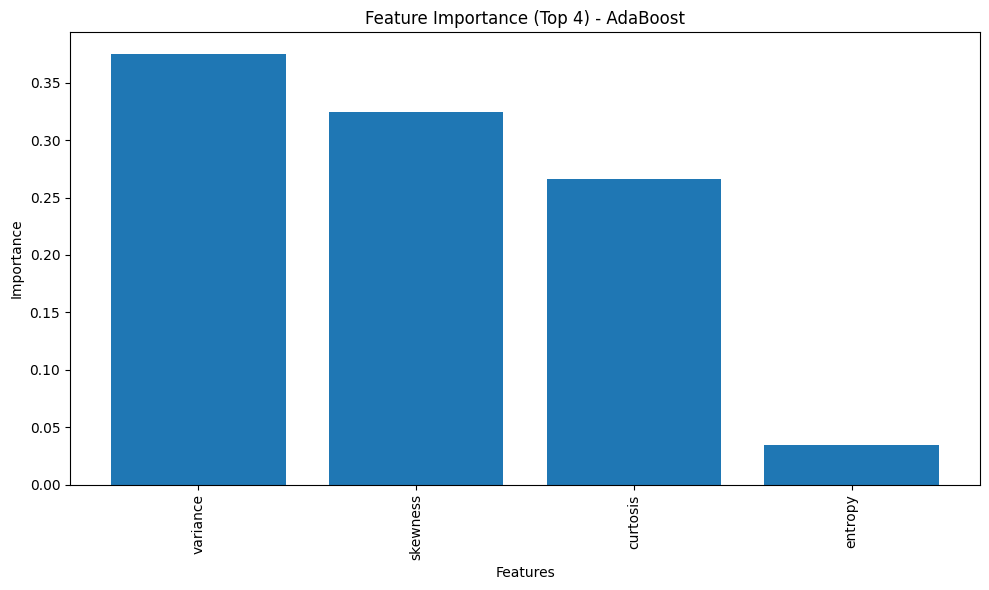

In [95]:
top_n = min(4, len(importances))
plt.figure(figsize=(10, 6))
plt.bar(range(top_n), importances[indices[:top_n]])
plt.xticks(range(top_n), [feature_column_names[i] for i in indices[:top_n]], rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title(f'Feature Importance (Top {top_n}) - {best_model_name}')
plt.tight_layout()
plt.show()

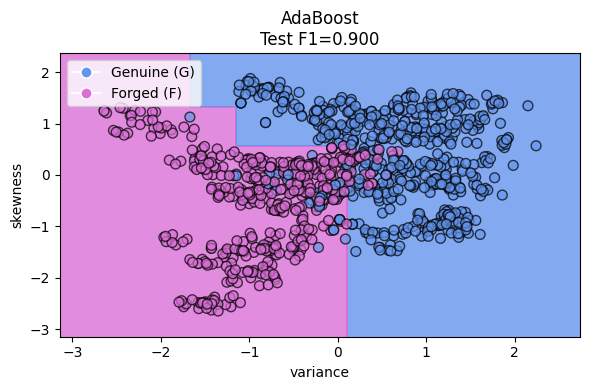


=== Modello: AdaBoost ===
   >> Stratified CV F1: 0.9214 (+/- 0.0208)
   >> Metriche test: {'Accuracy': 0.909, 'Precision': 0.876, 'Recall': 0.926, 'F1': 0.9}


In [96]:
results_fi = train_eval_2d_models(
    models=models_pca,
    X_train_2d=X_train_fi,
    X_test_2d=X_test_fi,
    y_train=y_train,
    y_test=y_test,
    feature_names_2d=feature_names_fi,
    strat_cv=strat_cv,
    task_type='binary',
    class_map=class_map,
    color_map_dict=color_map_dict,
    pos_label=TARGET_LABEL,
    do_plot=True
)

### 3. RFE - Recursive Feature Elimination

In [97]:
# RFE con il miglior modello
rfe = RFE(clone(best_model), n_features_to_select=2)
rfe.fit(X_train_scaled, y_train)

# Feature selezionate
rfe_selected_features = np.where(rfe.support_)[0]
print(f"\nFeatures selezionate da RFE: {[feature_column_names[i] for i in rfe_selected_features]}")

# Trasforma i dati
X_train_rfe = rfe.transform(X_train_scaled)
X_test_rfe = rfe.transform(X_test_scaled)
feature_names_rfe = [feature_column_names[i] for i in rfe_selected_features]


Features selezionate da RFE: ['variance', 'skewness']


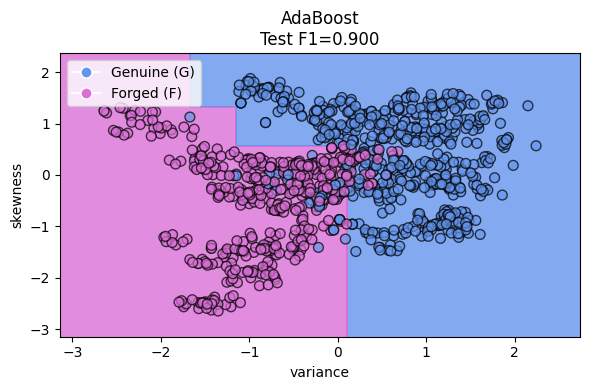


=== Modello: AdaBoost ===
   >> Stratified CV F1: 0.9214 (+/- 0.0208)
   >> Metriche test: {'Accuracy': 0.909, 'Precision': 0.876, 'Recall': 0.926, 'F1': 0.9}


In [98]:
results_rfe = train_eval_2d_models(
    models=models_pca,
    X_train_2d=X_train_rfe,
    X_test_2d=X_test_rfe,
    y_train=y_train,
    y_test=y_test,
    feature_names_2d=feature_names_rfe,
    strat_cv=strat_cv,
    task_type='binary',
    class_map=class_map,
    color_map_dict=color_map_dict,
    pos_label=TARGET_LABEL,
    do_plot=True
)

## 4. Mutual Information

In [99]:
# Calcola mutual information
mi_scores = mutual_info_classif(X_train_scaled, y_train, random_state=RANDOM_STATE)

# Seleziona top 2 features
mi_indices = np.argsort(mi_scores)[::-1][:2]

print(f"\nTop 2 features per MI: {[feature_column_names[i] for i in mi_indices]}")

# Seleziona le features
X_train_mi = X_train_scaled[:, mi_indices]
X_test_mi = X_test_scaled[:, mi_indices]
feature_names_mi = [feature_column_names[i] for i in mi_indices]


Top 2 features per MI: ['variance', 'skewness']


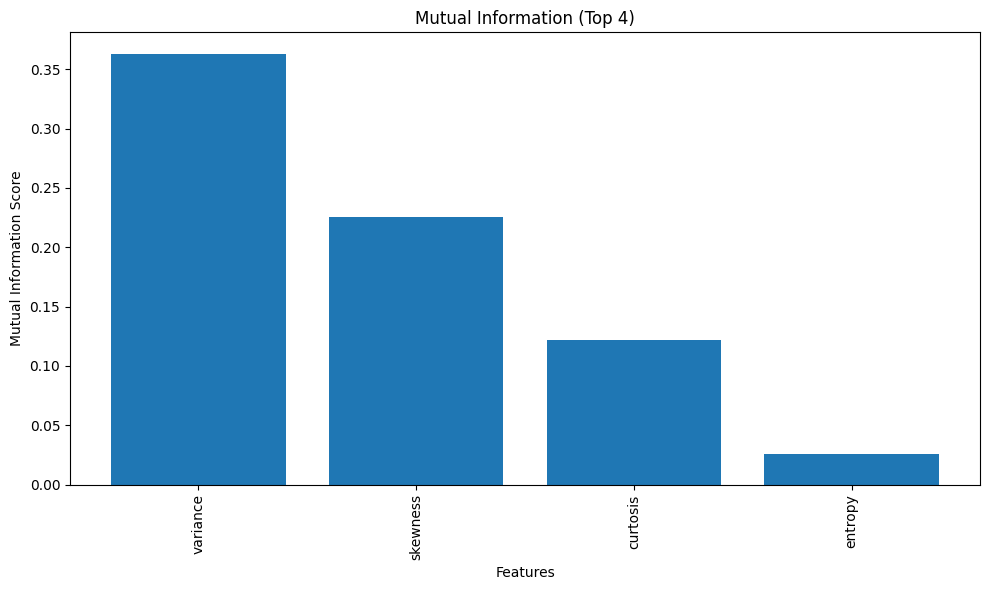

In [100]:
# Visualizza mutual information
top_n = min(4, len(mi_scores))
plt.figure(figsize=(10, 6))
mi_sorted_indices = np.argsort(mi_scores)[::-1][:top_n]
plt.bar(range(top_n), mi_scores[mi_sorted_indices])
plt.xticks(range(top_n), [feature_column_names[i] for i in mi_sorted_indices], rotation=90)
plt.xlabel('Features')
plt.ylabel('Mutual Information Score')
plt.title(f'Mutual Information (Top {top_n})')
plt.tight_layout()
plt.show()

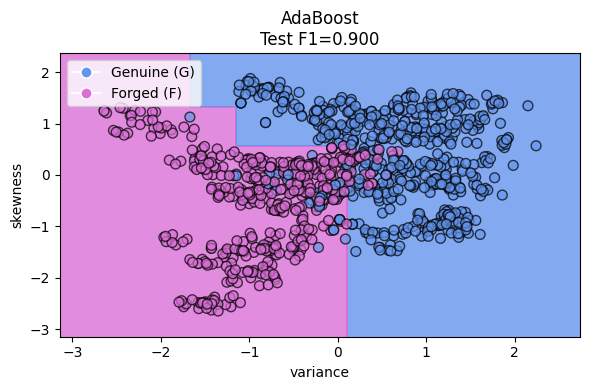


=== Modello: AdaBoost ===
   >> Stratified CV F1: 0.9214 (+/- 0.0208)
   >> Metriche test: {'Accuracy': 0.909, 'Precision': 0.876, 'Recall': 0.926, 'F1': 0.9}


In [101]:
results_mi = train_eval_2d_models(
    models=models_pca,
    X_train_2d=X_train_mi,
    X_test_2d=X_test_mi,
    y_train=y_train,
    y_test=y_test,
    feature_names_2d=feature_names_mi,
    strat_cv=strat_cv,
    task_type='binary',
    class_map=class_map,
    color_map_dict=color_map_dict,
    pos_label=TARGET_LABEL,
    do_plot=True
)

In [102]:
df_compare = pd.DataFrame({
    "Original": df_results["F1"][best_model_name],
    "PCA": results_pca[best_model_name]["metrics"]["F1"],
    "Feature Importance": results_fi[best_model_name]["metrics"]["F1"],
    "RFE": results_rfe[best_model_name]["metrics"]["F1"],
    "Mutual Information": results_mi[best_model_name]["metrics"]["F1"],
}, index=["F1"])

print(f"\nConfronto metodi di Feature Selection per {best_model_name}:")
df_compare


Confronto metodi di Feature Selection per AdaBoost:


,Original,PCA,Feature Importance,RFE,Mutual Information
F1,1.0,0.791,0.9,0.9,0.9


<Figure size 1000x600 with 0 Axes>

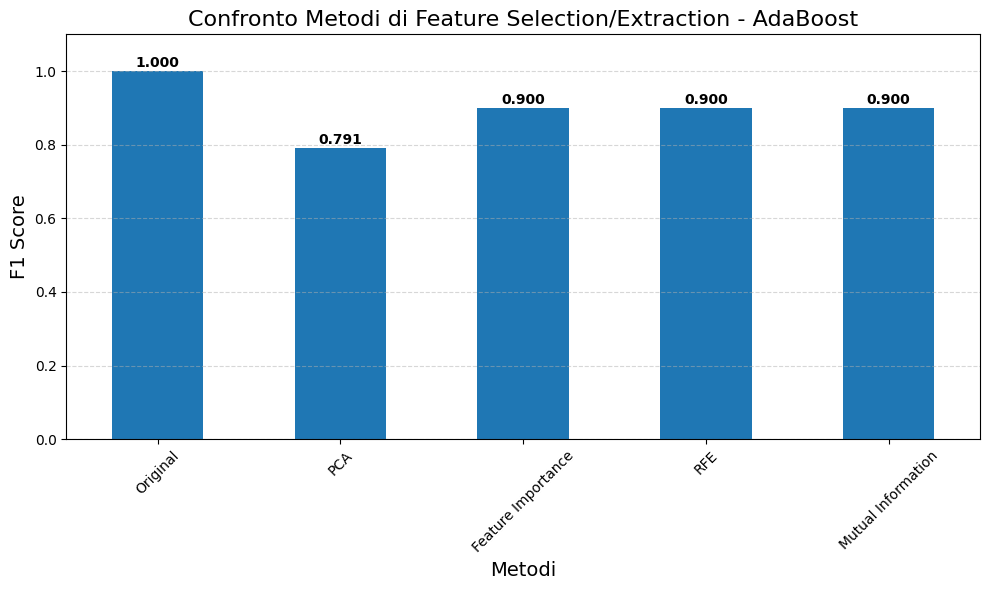

In [103]:
# Visualizza confronto
plt.figure(figsize=(10, 6))
df_compare.T.plot(kind='bar', figsize=(10,6), legend=False)
plt.title(f"Confronto Metodi di Feature Selection/Extraction - {best_model_name}", fontsize=16)
plt.ylabel("F1 Score", fontsize=14)
plt.xlabel("Metodi", fontsize=14)
plt.xticks(rotation=45)
plt.ylim(0, 1.1)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Aggiungi valori sopra le barre
ax = plt.gca()
for i, v in enumerate(df_compare.values[0]):
    ax.text(i, v + 0.01, f'{v:.3f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()